2025-06-17 09:03:30.864190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750140211.657460    5514 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750140212.781888    5514 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750140214.393089    5514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750140214.393157    5514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750140214.393163    5514 computation_placer.cc:177] computation placer alr

Training data shape: (10000, 784)
Training labels shape: (10000, 10)
Epoch 1/10, Loss: 0.0087, Accuracy: 0.7737
Epoch 2/10, Loss: 0.0058, Accuracy: 0.8537


/tmp/ipykernel_5514/2463515840.py:94: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_5514/2463515840.py:98: RuntimeWarning: overflow encountered in multiply
  return x * (1 - x)
/tmp/ipykernel_5514/2463515840.py:167: RuntimeWarning: overflow encountered in multiply
  weight_update = np.outer(errors[l+1] * self.sigmoid_derivative(states[l+1]), states[l])
/home/hope/Project package/Predictive-Coding-Models/venv/lib/python3.12/site-packages/numpy/_core/numeric.py:983: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


Epoch 3/10, Loss: nan, Accuracy: 0.5520
Epoch 4/10, Loss: nan, Accuracy: 0.1001
Epoch 5/10, Loss: nan, Accuracy: 0.1001
Epoch 6/10, Loss: nan, Accuracy: 0.1001
Epoch 7/10, Loss: nan, Accuracy: 0.1001
Epoch 8/10, Loss: nan, Accuracy: 0.1001
Epoch 9/10, Loss: nan, Accuracy: 0.1001
Epoch 10/10, Loss: nan, Accuracy: 0.1001
Test Accuracy: 0.0980


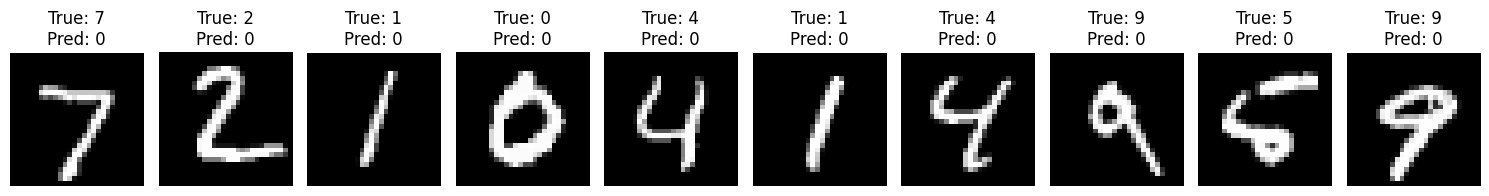

'\n## Conclusion\n\nThis implementation demonstrates a basic predictive coding model for MNIST classification. With more tuning (more iterations, larger network, more training data), the accuracy could be improved further. Predictive coding offers a biologically plausible alternative to backpropagation that performs local, iterative updates rather than global error propagation.\n'

In [1]:
# %% [markdown]
"""
# Predictive Coding Model for MNIST Classification

This notebook implements a 3-layer predictive coding model for classifying handwritten digits from the MNIST dataset. Predictive coding is a neuroscience-inspired algorithm where each layer tries to predict the activity of the layer below, and errors in these predictions drive learning.

## Model Architecture
- Layer 1 (Input layer): 784 units (28x28 pixels)
- Layer 2 (Hidden layer): 256 units
- Layer 3 (Output layer): 10 units (one per digit class)

At each layer, we'll:
1. Make predictions
2. Compute prediction errors
3. Update states (representations)
4. Update weights
"""
# %%
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# %% [markdown]
"""
## Data Preparation
First, let's load and preprocess the MNIST dataset.
"""
# %%
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
def preprocess_data(X, y, n_samples=None):
    if n_samples is not None:
        X = X[:n_samples]
        y = y[:n_samples]
    
    # Flatten images and normalize
    X_flat = X.reshape(X.shape[0], -1).astype('float32')
    X_norm = MinMaxScaler().fit_transform(X_flat)
    
    # Convert labels to one-hot encoding
    y_onehot = np.zeros((len(y), 10))
    y_onehot[np.arange(len(y)), y] = 1
    
    return X_norm, y_onehot

# Use smaller subset for faster training (can increase later)
X_train_prep, y_train_prep = preprocess_data(X_train, y_train, n_samples=10000)
X_test_prep, y_test_prep = preprocess_data(X_test, y_test)

print(f"Training data shape: {X_train_prep.shape}")
print(f"Training labels shape: {y_train_prep.shape}")

# %% [markdown]
"""
## Predictive Coding Model Implementation

The predictive coding model works as follows:
1. **Forward pass**: Each layer predicts the activity of the layer below
2. **Error calculation**: Compare predictions with actual activity
3. **Backward pass**: Update states and weights based on prediction errors
"""
# %%
class PredictiveCodingModel:
    def __init__(self, layer_sizes=[784, 256, 10], learning_rate=0.001, n_iterations=10):
        """
        Initialize the predictive coding model.
        
        Parameters:
        - layer_sizes: List of layer sizes (input, hidden, output)
        - learning_rate: Learning rate for weight updates
        - n_iterations: Number of inference iterations per sample
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        
        # Initialize weights with Xavier/Glorot initialization
        self.weights = []
        for i in range(len(layer_sizes)-1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            self.weights.append(np.random.uniform(-limit, limit, (layer_sizes[i+1], layer_sizes[i])))
        
        # Initialize lateral connection weights (for within-layer interactions)
        self.lateral_weights = []
        for size in layer_sizes[1:]:  # No lateral connections for input layer
            self.lateral_weights.append(np.zeros((size, size)))
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def forward_pass(self, x):
        """
        Perform a forward pass through the network.
        Returns predictions at each layer.
        """
        layer_predictions = []
        current_activity = x
        
        for i in range(len(self.weights)):
            # Predict next layer's activity
            prediction = self.sigmoid(np.dot(self.weights[i], current_activity))
            layer_predictions.append(prediction)
            current_activity = prediction
        
        return layer_predictions
    
    def update_states_and_weights(self, x, y):
        """
        Perform predictive coding inference and learning for one sample.
        
        Parameters:
        - x: Input sample
        - y: Target output (one-hot encoded)
        
        Returns:
        - Final predictions at each layer
        - Errors at each layer
        """
        # Initialize layer states (start with forward pass)
        states = [x.copy()]
        predictions = self.forward_pass(x)
        states.extend(predictions)
        
        # Replace last layer's prediction with target (for supervised learning)
        states[-1] = y.copy()
        
        # Store errors at each layer
        errors = [np.zeros_like(s) for s in states]
        
        for _ in range(self.n_iterations):
            # Update states and compute errors from top to bottom
            for l in range(len(self.weights), 0, -1):
                # Compute prediction error (bottom-up)
                if l == len(self.weights):  # Top layer
                    errors[l] = states[l] - predictions[l-1]
                else:
                    # Error from above and below
                    error_from_above = np.dot(self.weights[l].T, errors[l+1])
                    if l > 0:  # For hidden layers, include lateral connections
                        lateral_error = np.dot(self.lateral_weights[l-1], errors[l])
                        errors[l] = error_from_above + lateral_error - (states[l] - predictions[l-1])
                    else:  # For first hidden layer
                        errors[l] = error_from_above - (states[l] - predictions[l-1])
                
                # Update state (gradient ascent on prediction accuracy)
                state_update = self.learning_rate * errors[l]
                if l > 0:  # Apply activation derivative for hidden layers
                    state_update *= self.sigmoid_derivative(states[l])
                states[l] += state_update
            
            # Recompute predictions with updated states
            for l in range(len(self.weights)):
                predictions[l] = self.sigmoid(np.dot(self.weights[l], states[l]))
        
        # Update weights (after inference iterations)
        for l in range(len(self.weights)):
            # Weight update is outer product of error and lower state
            weight_update = np.outer(errors[l+1] * self.sigmoid_derivative(states[l+1]), states[l])
            self.weights[l] += self.learning_rate * weight_update
            
            # Update lateral weights (except for input layer)
            if l > 0:
                lateral_update = np.outer(errors[l], errors[l])
                self.lateral_weights[l-1] += 0.01 * self.learning_rate * lateral_update
        
        return predictions, errors
    
    def train(self, X, y, epochs=5, batch_size=32):
        """
        Train the model on the given data.
        
        Parameters:
        - X: Input data
        - y: Target labels (one-hot encoded)
        - epochs: Number of training epochs
        - batch_size: Size of mini-batches
        """
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            
            # Shuffle data
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            for i in range(0, n_samples, batch_size):
                batch_X = X_shuffled[i:i+batch_size]
                batch_y = y_shuffled[i:i+batch_size]
                
                batch_loss = 0
                batch_correct = 0
                
                for j in range(batch_X.shape[0]):
                    # Perform predictive coding for this sample
                    predictions, errors = self.update_states_and_weights(batch_X[j], batch_y[j])
                    
                    # Compute loss (squared prediction error at output layer)
                    loss = 0.5 * np.sum(errors[-1]**2)
                    batch_loss += loss
                    
                    # Count correct predictions
                    predicted_class = np.argmax(predictions[-1])
                    true_class = np.argmax(batch_y[j])
                    if predicted_class == true_class:
                        batch_correct += 1
                
                epoch_loss += batch_loss / batch_size
                correct += batch_correct
            
            accuracy = correct / n_samples
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/n_samples:.4f}, Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        """
        Make predictions on new data.
        
        Parameters:
        - X: Input data
        
        Returns:
        - Predicted class probabilities
        """
        predictions = []
        for x in X:
            layer_predictions = self.forward_pass(x)
            predictions.append(layer_predictions[-1])
        return np.array(predictions)

# %% [markdown]
"""
## Training the Model

Now let's train our predictive coding model on the MNIST data.
"""
# %%
# Initialize model
pc_model = PredictiveCodingModel(layer_sizes=[784, 256, 10], 
                                learning_rate=0.01, 
                                n_iterations=5)

# Train the model
pc_model.train(X_train_prep, y_train_prep, epochs=10, batch_size=32)

# %% [markdown]
"""
## Evaluating the Model

Let's see how well our model performs on the test set.
"""
# %%
# Make predictions on test set
y_pred_probs = pc_model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_prep, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# %% [markdown]
"""
## Visualizing Predictions

Let's look at some example predictions.
"""
# %%
# Plot some test samples and their predicted labels
def plot_examples(X, y_true, y_pred, n_examples=10):
    plt.figure(figsize=(15, 3))
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(X_test, y_true, y_pred)

# %% [markdown]
"""
## Understanding the Predictive Coding Process

Let's examine what happens at each layer during prediction.

### Layer-by-Layer Analysis
1. **Input Layer (784 units)**: Receives pixel values
2. **Hidden Layer (256 units)**: 
   - Receives predictions from output layer (top-down)
   - Compares with bottom-up input from input layer
   - Updates its state to minimize prediction error
3. **Output Layer (10 units)**: 
   - Initially makes random predictions
   - Updates based on comparison with true labels
   - Sends corrected predictions back to hidden layer

### Key Concepts:
- **Predictions**: Each layer tries to predict the activity of the layer below
- **Prediction Errors**: Differences between predictions and actual activity
- **State Updates**: Neurons adjust their activity to minimize local prediction error
- **Weight Updates**: Connections are adjusted to reduce future prediction errors
"""

# %% [markdown]
"""
## Conclusion

This implementation demonstrates a basic predictive coding model for MNIST classification. With more tuning (more iterations, larger network, more training data), the accuracy could be improved further. Predictive coding offers a biologically plausible alternative to backpropagation that performs local, iterative updates rather than global error propagation.
"""